In [1]:
import pandas as pd
import psycopg2
from tqdm import tqdm
from multiprocessing import Pool
from functools import partial
import numpy as np
from collections import Counter
import time 
import requests 
import pickle
import random 
import matplotlib.pyplot as plt
import glob 

main_path = '/home/fs01/spec1142/Emma/GateKeepers/'


f = open('/home/fs01/spec1142/Emma/GateKeepers/' + "database.txt", "r")
user , password = f.read().split()


## Load files 

In [4]:
institutions = pd.read_csv(main_path + "data_description/data/institutions_up_to_20230817.tsv" , delimiter = "\t", index_col = 0)
US_institutions = institutions[institutions['country_code'] == 'US']
list_US_institutions = set(US_institutions.index)

set_university_institutions = set(institutions[institutions['type'] == 'education'].index)
set_university_company = set(institutions[institutions['type'] == 'company'].index)


df_gatekeepers = pd.read_csv(main_path+ "gatekeepers_intermediate_clean_v5.tsv" , delimiter = "\t")

PPPs = pd.read_csv(main_path+'regressions/PPPs_v2.tsv', delimiter = '\t')


In [5]:
list_concepts = ['https://openalex.org/C41008148',
 'https://openalex.org/C71924100',
 'https://openalex.org/C86803240',
 'https://openalex.org/C17744445',
'https://openalex.org/C185592680',
'https://openalex.org/C192562407']

#create a URl, that will be used for OpenAlex and Patentsview
def URL(base_URL , entity_type , filters):
    url = base_URL + entity_type + filters 
    return url

#from an internet link, extract the data and load the data in the jyputer notebook 
def get_data(url):
    url = requests.get(url)
    text = url.text
    import json
    data = json.loads(text)
    return data

list_concepts1 = []
base_URL_OA = f'https://api.openalex.org/'
filter_works = f'concepts?filter='
for concept in list_concepts:
    filter_by_date = "ancestors.id:" + concept + ",level:1&page=" + str(1) + "&sort=works_count:desc&per-page=" + str(200) + "&mailto=emma_scharfmann@berkeley.edu" 
    url = URL(base_URL_OA , filter_works, filter_by_date)
    data = get_data(url)["results"]
    for k in range(len(data)):
        list_concepts1.append(data[k]["display_name"] )

set_concepts1 = set(list_concepts1)
list_concepts1 

['Artificial intelligence',
 'Programming language',
 'Operating system',
 'World Wide Web',
 'Library science',
 'Algorithm',
 'Telecommunications',
 'Computer security',
 'Machine learning',
 'Computer network',
 'Information retrieval',
 'Computer vision',
 'Database',
 'Data mining',
 'Data science',
 'Knowledge management',
 'Embedded system',
 'Human–computer interaction',
 'Computer graphics (images)',
 'Internet privacy',
 'Natural language processing',
 'Software engineering',
 'Theoretical computer science',
 'Distributed computing',
 'Multimedia',
 'Simulation',
 'Real-time computing',
 'Parallel computing',
 'Computer hardware',
 'Speech recognition',
 'Computer architecture',
 'Computational science',
 'Computer engineering',
 'Internal medicine',
 'Pathology',
 'Surgery',
 'Immunology',
 'Endocrinology',
 'Psychiatry',
 'Environmental health',
 'Radiology',
 'Nursing',
 'Anatomy',
 'Cardiology',
 'Pharmacology',
 'Virology',
 'Gynecology',
 'Family medicine',
 'Intensive 

# Papers

## Get all US papers

In [6]:
def papers_by_year(year):

    """
    This function retrieves US papers published in a specific year along with their citation counts, concepts, authors, institutions, and referenced works from a PostgreSQL database and saves the data to a JSON file.

    Parameters:
    year (int): The year for which to retrieve papers.

    Note:
    - The function assumes that the `user`, `password`, and `main_path` variables are defined elsewhere in the code.
    - The function establishes a connection to a PostgreSQL database using the `psycopg2` library and executes a SQL query to fetch the required data.
    - The function filters the results to only include papers where at least one author is affiliated with a US institution (as defined by the `list_US_institutions` variable).
    - The function stores the retrieved data in a dictionary and then converts the dictionary to a JSON object.
    - The function saves the JSON object to a file (named "dic_papers_citations_year.json", where year is the input year).
    - The function closes the database connection after fetching the data.
    """
    
    conn = psycopg2.connect("user=" + user + " password=" + password)
    cursor = conn.cursor()

    
    text = """select  w.work_id , w.cited_by_count, w.concepts, array_agg(wa.author_id), array_agg(wa.institution_id), w.referenced_works
              from works_authors_OpenAlex AS wa
              join works_OpenAlex AS w ON w.work_id = wa.work_id
              where EXTRACT('Year' FROM w.publication_date) = """ + str(year) + """
              GROUP BY w.work_id , w.cited_by_count, w.concepts,  w.referenced_works
              ;"""
    cursor.execute(text)
    res = cursor.fetchall()

    print(len(res))

    
    dic_works = {}
    
    
    for elem in res:
        work_id = elem[0]
        citations = elem[1]
        if elem[2] != None:
            concepts = elem[2].split('; ')
        else:
            concepts = None
        authors = elem[3]
        institutions = set(elem[4] )
        if elem[5] != None:
            backward_cites = len(elem[5].split('; '))
        else:
            backward_cites = None
        
        if len(list_US_institutions & institutions) > 0:
            dic_works[work_id] = {}
            dic_works[work_id]['cites'] = citations
            dic_works[work_id]['concepts'] = concepts
            dic_works[work_id]['authors'] = authors
            dic_works[work_id]['concepts'] = concepts
            dic_works[work_id]['institutions'] = list(institutions)
            dic_works[work_id]['year'] = year
            dic_works[work_id]['backward_cites'] = backward_cites

    import json
    json = json.dumps(dic_works)
    f = open(main_path + "regressions/dic_papers_citations_" + str(year) + ".json","w")
    f.write(json)
    f.close()


    cursor.close()
    

In [5]:
## parallelize the code

import warnings        
from multiprocessing import Process


if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",UserWarning)
        
        processes = [Process(target=papers_by_year, args=(k,)) for k in range(2016,2023)]
        
        for process in processes:
            process.start()
            
        for process in processes:
            process.join()

7394871
9236788
8421948
8792634
8707262
8952369
8950169


In [24]:
## put the files together 

dic_works = {}
for year in tqdm(range(1980,2023)):

    f = open(main_path + "regressions/dic_papers_citations_" + str(year) + ".json","r")
    import json
    dic = json.load(f)
    
    dic_works = { **dic_works , **dic} 


import json
json = json.dumps(dic_works)
f = open(main_path + "regressions/dic_papers_citations.json","w")
f.write(json)
f.close()

100%|███████████████████████████████████████████| 43/43 [12:52<00:00, 17.96s/it]


## Create regression file: papers citations / novelty 

In [2]:
f = open(main_path + "regressions/dic_papers_citations.json","r")
import json
dic = json.load(f)

In [6]:
## keep high confidence SIs

threshold = 0.5
df_gatekeepers = df_gatekeepers[df_gatekeepers['number of match'] / df_gatekeepers['number of comparison'] > threshold ]
set_authors_GK = set(list(df_gatekeepers['author_id']))

In [7]:
## load active authors and corresponding active years 
with open(main_path + "data_description/data/active_authors_05", "rb") as fp:  
    set_active_GK = set(pickle.load(fp))


In [8]:
## select most frequent element of a list
def most_frequent(List):
    if List != None:
        random.shuffle(List)
        occurence_count = Counter(List)
        return occurence_count.most_common(1)[0][0]
    else:
        return None

In [11]:
## for each paper, generate independant variables and fixed effects 

dic2 = {} 
concepts = ['Computer science','Medicine','Biology','Physics','Chemistry','Materials science']



for elem in tqdm(list(dic.keys())):
    set_authors = set(dic[elem]['authors'])
    year = dic[elem]['year']

    ## count the number of active SIs, career SIs, pure authors 
    dic[elem]['number_only_authors'] = len(set_authors - set_authors_GK)
    dic[elem]['number_active_gks'] = 0
    dic[elem]['number_career_gks'] = 0
    gk_authors = set_authors & set_authors_GK

    ## the author year is active it (author id, year) is in the file. Otherwise, it's a career year
    for author in gk_authors:
        if (author, int(year)) in set_active_GK:
            dic[elem]['number_active_gks'] += 1
        else:
            dic[elem]['number_career_gks'] +=1

    dic[elem]['random_author'] = random.choice(dic[elem]['authors'])

    ## select a random concept level 1 for fixed effect
    concept_level1 = list(set(dic[elem]['concepts']) &  set_concepts1)
    random.shuffle(concept_level1) 
    if len(concept_level1) > 0:
        dic[elem]['concept1'] = concept_level1[0]
    else:
        dic[elem]['concept1'] = None
    
    ## get the concept level 0 for fixed effects
    for concept in concepts:
        if concept in set(dic[elem]['concepts']):
            dic[elem][concept] = 1
        else:
            dic[elem][concept] = 0

    if len( set(dic[elem]['institutions']) & set_university_institutions ) > 0:
        dic[elem]['education'] = 1
    else:
        dic[elem]['education'] = 0

    if len( set(dic[elem]['institutions']) & set_university_company ) > 0:
        dic[elem]['company'] = 1
    else:
        dic[elem]['company'] = 0
    

    
    ## keep the papers by SIs for the regression by year
    if  dic[elem]['number_active_gks'] > 0 or  dic[elem]['number_career_gks'] > 0:
        dic2[elem] = dic[elem]
    


100%|████████████████████████████| 21458438/21458438 [06:26<00:00, 55481.21it/s]


In [12]:
##save the papers by SIs for the regression by year

import json
json = json.dumps(dic2)
f = open(main_path + "regressions/dic_papers_citations_gk_only05.json","w")
f.write(json)
f.close()
print(len(dic2))

6514812


In [14]:
## flatten the file. 

values = dic.values()

df = pd.DataFrame()
df['work_id'] = dic.keys()
df['number_only_authors'] = [ elem['number_only_authors'] for elem in values] 
df['number_active_gks'] = [ elem['number_active_gks'] for elem in values] 
df['number_career_gks'] = [ elem['number_career_gks'] for elem in values] 
df['pubyear'] = [ elem['year'] for elem in values] 
df['cites'] = [ elem['cites'] for elem in values] 
df['institution'] = [ most_frequent(elem['institutions']) for elem in values] 
df['backward_cites'] = [ elem['backward_cites'] for elem in values] 
df['random_author'] = [ elem['random_author'] for elem in values] 
df['education'] = [ elem['education'] for elem in values] 
df['company'] = [ elem['company'] for elem in values] 

for concept in concepts:
    df[concept] = [ elem[concept] for elem in values] 

df['concept1'] = [ elem['concept1'] for elem in values]

In [15]:
## save the flat file. 

df.to_csv(main_path + "regressions/papers_citers_novelty_regression05.tsv", sep = "\t", index = False)

In [50]:
## load the flat file. 

df= pd.read_csv(main_path + "GateKeepers/papers_citers_novelty_regression05.tsv", delimiter = "\t")

In [16]:
## add paper novelty 

novelty_files = pd.read_csv(main_path + 'novelty_measure/data/novelty_papers_1980_2023.tsv', delimiter = '\t', index_col = 0 ) 
novelty_files = novelty_files.drop_duplicates('work_id')
novelty_files.head()

df_nov = df.merge(novelty_files , on='work_id', how='left')

In [17]:
## add PPPs 

set_PPPs = set(list(PPPs['paper_id']))
df_nov['PPP'] = [ 1 if work_id in set_PPPs else 0 for work_id in df_nov['work_id'] ] 

In [18]:
## transform string columns to int

df_nov['institution_int'] = df_nov['institution'].factorize()[0]
df_nov['concept1_int'] = df_nov['concept1'].factorize()[0]
df_nov['random_author_int'] = df_nov['random_author'].factorize()[0]


In [19]:
# Calculate the 95th percentile within each group
percentiles = df_nov.groupby(['pubyear', 'concept1_int'])['cites'].transform(lambda x: x.quantile(0.95))

# Create a new column 'top_5_percent' based on the condition
df_nov['top_5_percent'] = df_nov['cites'] >= percentiles
df_nov['top_5_percent'] = df_nov['top_5_percent'].replace(False,0)
df_nov['top_5_percent'] = df_nov['top_5_percent'].replace(True,1)


In [20]:
## flat year/concept with a proportion of top 5% that is too high 

check_5percent = df_nov[['work_id','pubyear','concept1_int']].groupby(['pubyear','concept1_int']).count()
check_5percent1 = df_nov[['pubyear','concept1_int','top_5_percent']].groupby(['pubyear','concept1_int']).mean()
check_5percent1 = check_5percent1.reset_index()
flat_5percent = check_5percent1[check_5percent1['top_5_percent'] > 0.065]
check_year_concept = flat_5percent[['pubyear','concept1_int']].to_numpy()
check_year_concept = set(list([ (elem[0] , elem[1] ) for elem in check_year_concept]))
df_nov['check_5percent'] = [ 1 if (elem[0], elem[1]) in check_year_concept else 0 for elem in df_nov[['pubyear','concept1_int']].to_numpy()]


In [21]:
## save paper regression file 

df_nov[['work_id', 'number_only_authors', 'number_active_gks',
       'number_career_gks', 'pubyear', 'cites',
       'backward_cites', 'Computer science', 'Medicine', 'Biology', 'Physics',
       'Chemistry', 'Materials science', 'novelty', 'PPP',
       'institution_int', 'concept1_int','top_5_percent','check_5percent','company','education']].to_stata(main_path + 'regressions/science_papers_cites_novelty_05.dta')

/tmp/ipykernel_571347/1176002968.py:3: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    Computer science   ->   Computer_science
    Materials science   ->   Materials_science

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  df_nov[['work_id', 'number_only_authors', 'number_active_gks',


## Create regression file: SI papers - year citations / novelty 

### Create the scientist - year data (for all SIs)

In [4]:
## load papers with at least one SI. The papers are limited to US papers. 

f = open(main_path + "regressions/dic_papers_citations_gk_only02.json","r")
import json
dic = json.load(f)

In [5]:
## for each author, for each year the author publishes, get cites, number of works, all concepts 

dic_scientist_papers = {}
count = 0 

for elem in tqdm(dic):
    work = elem 
    authors = dic[elem]['authors']
    year = dic[elem]['year']
    cites = dic[elem]['cites']
    concepts = dic[elem]['concepts']

    for author_id in authors:
        if author_id not in dic_scientist_papers:
            dic_scientist_papers[author_id] = {}
        if year not in dic_scientist_papers[author_id]:
            dic_scientist_papers[author_id][year] = { 'cites' : 0 , 'works' : [], 'concepts' : [] } 

        dic_scientist_papers[author_id][year]['cites'] += cites
        dic_scientist_papers[author_id][year]['works'].append(work)
        dic_scientist_papers[author_id][year]['concepts'] += concepts
        
            


100%|██████████████████████████████| 7146620/7146620 [07:02<00:00, 16934.98it/s]


In [6]:
## count the authors who published only one year in their career. 

count = 0 
for author_id in tqdm(dic_scientist_papers):
    if len(dic_scientist_papers[author_id]) == 1:
        count += 1
print(count)

100%|████████████████████████████| 5858049/5858049 [00:05<00:00, 1054186.46it/s]

2897952


In [7]:
## only keep the authors who published multiple years in their career

dic_scientist_papers2= {}
for author_id in tqdm(dic_scientist_papers):
    if len(dic_scientist_papers[author_id]) > 1:
        dic_scientist_papers2[author_id] = dic_scientist_papers[author_id]


100%|█████████████████████████████| 5858049/5858049 [00:06<00:00, 913124.85it/s]


In [8]:
## load novelty file. Transform novelty file into a dictionary with work ids as keys. 

## add paper novelty 

novelty_files = pd.read_csv(main_path + 'novelty_measure/data/novelty_papers_1980_2023.tsv', delimiter = '\t', index_col = 0 ) 
novelty_files = novelty_files.drop_duplicates('work_id')

novelty_files_sm = novelty_files[novelty_files['work_id'].isin(dic.keys())]
novelty_files_sm = novelty_files_sm.drop_duplicates('work_id')
novelty_files_sm = novelty_files_sm.set_index('work_id')
dic_novelty_files_sm = novelty_files_sm.to_dict('index')

In [9]:
## for each author and year, get the mean of the novelty. If no paper has an abstract, the novelty is None. 

for author_id in tqdm(dic_scientist_papers2):
    for year in dic_scientist_papers2[author_id]:
        dic_scientist_papers2[author_id][year]['novelty'] = []
        for work_id in dic_scientist_papers2[author_id][year]['works']:
            if work_id in dic_novelty_files_sm:
                dic_scientist_papers2[author_id][year]['novelty'].append(dic_novelty_files_sm[work_id]['novelty'])
        if len(dic_scientist_papers2[author_id][year]['novelty']) > 0:
            dic_scientist_papers2[author_id][year]['novelty_mean'] = sum(dic_scientist_papers2[author_id][year]['novelty']) / len(dic_scientist_papers2[author_id][year]['novelty'])
        else:
            dic_scientist_papers2[author_id][year]['novelty_mean'] = None

100%|██████████████████████████████| 2960097/2960097 [03:42<00:00, 13291.46it/s]


In [10]:
## get the concept for each author and year. 
## level 0 concept: 1 if at least a paper corresponds to the level 0 concept
## level 1 concept: 1 random level 1 concept of the author's papers published in a given year

import random 

concepts = ['Computer science','Medicine','Biology','Physics','Chemistry','Materials science']

for author_id in tqdm(dic_scientist_papers2):
    for year in dic_scientist_papers2[author_id]:
        concepts_si = set(dic_scientist_papers2[author_id][year]['concepts'])
        concept_level1 = list(concepts_si &  set_concepts1)
        random.shuffle(concept_level1) 
        if len(concept_level1) > 0:
            dic_scientist_papers2[author_id][year]['concept1'] = concept_level1[0]
        else:
            dic_scientist_papers2[author_id][year]['concept1'] = None

        for concept in concepts:
            if concept in concepts_si:
                dic_scientist_papers2[author_id][year][concept] = 1
            else:
                dic_scientist_papers2[author_id][year][concept] = 0 

100%|██████████████████████████████| 2960097/2960097 [03:36<00:00, 13669.42it/s]


In [10]:
## save the file. all the authors in the file are not SIs, but are co-authors of SIs. 

import json
json = json.dumps(dic_scientist_papers2)
f = open(main_path + "regressions/dic_scientist_years02.json","w")
f.write(json)
f.close()

In [11]:
## store the data as a flat file. Each row corresponds to author id - year. 
concepts = ['Computer science','Medicine','Biology','Physics','Chemistry','Materials science']

flat_dic = {}
count = 0 

for author_id in tqdm(dic_scientist_papers2):
    
    first_year = min(list(dic_scientist_papers2[author_id].keys()))
    
    for year in dic_scientist_papers2[author_id]:
        flat_dic[count] = {}
        flat_dic[count]['author_id'] = author_id
        flat_dic[count]['year'] = year
        flat_dic[count]['count_year'] = int(year) - int(first_year)
        flat_dic[count]['nb_works'] = len(dic_scientist_papers2[author_id][year]['works'])
        flat_dic[count]['works'] = dic_scientist_papers2[author_id][year]['works']
        flat_dic[count]['cites'] = dic_scientist_papers2[author_id][year]['cites']
        flat_dic[count]['novelty'] = dic_scientist_papers2[author_id][year]['novelty_mean']
        
        
        for concept in concepts:
            flat_dic[count][concept] = dic_scientist_papers2[author_id][year][concept]
        flat_dic[count]['concept1'] = dic_scientist_papers2[author_id][year]['concept1']
        count += 1



100%|██████████████████████████████| 2960097/2960097 [02:12<00:00, 22345.78it/s]


In [12]:
## save the flat file 

import json
json = json.dumps(flat_dic)
f = open(main_path + "regressions/dic_scientist_years_flat02.json","w")
f.write(json)
f.close()

### Add number of SIs 

In [8]:
## load papers with at least one SI. The papers are limited to US papers. 

f = open(main_path + "regressions/dic_papers_citations_gk_only.json","r")
import json
dic = json.load(f)

In [9]:
## load the flat file 

f = open(main_path + "regressions/dic_scientist_years_flat.json","r")
import json
flat_dic = json.load(f)

In [13]:
## load active, career SIs

import pickle 

threshold = 0.2

df_gatekeepers = pd.read_csv(main_path+ "gatekeepers_intermediate_clean_v5.tsv" , delimiter = "\t")
df_gatekeepers = df_gatekeepers[df_gatekeepers['number of match'] / df_gatekeepers['number of comparison'] > threshold]
authors_gk = set(list(df_gatekeepers['author_id']))

with open(main_path + "data_description/data/active_authors_02", "rb") as fp:  
    set_active_gk = set(pickle.load(fp))



In [15]:
## load top 5% most cited papers (breakthrough)

df_nov = pd.read_stata(main_path + 'regressions/science_papers_cites_novelty_02.dta')
top5percent = set(list(df_nov[df_nov['top_5_percent'] == 1]['work_id']))

In [16]:
## count number of co-authors (active, career, author_only) + add PPPs

PPPs_papers = set(list(PPPs['paper_id']))
flat_dic2 = {}

for count in tqdm(flat_dic):

    author_id = flat_dic[count]['author_id'] 

    ## check if the author is an SI
    if author_id in authors_gk:

        set_works = set(flat_dic[count]['works'])
        year = flat_dic[count]['year']

        ## count number of PPP published during a given year
        flat_dic[count]['PPPs'] = len(PPPs_papers & set_works)

        ## count number of 'breakthrough' published during a given year
        flat_dic[count]['top5percent'] = len( set_works & top5percent ) 
        
        authors = []

        ## store number of co-authors during the given year
        for work_id in flat_dic[count]['works']:
            authors += dic[work_id]['authors']

        ## remove itself from the co-author list 
        set_authors = set(authors) - { author_id } 

        ## count pure scientists 
        flat_dic[count]['co_authors_only'] = len(set_authors - authors_gk)
        flat_dic[count]['co_authors_active'] = 0
        flat_dic[count]['co_authors_career'] = 0
        for author in set_authors:

            ## if the (author id, year) is in the active list, the year is active
            if (author, int(year)) in set_active_gk:
                flat_dic[count]['co_authors_active'] += 1
            ## otherwise, it's career
            else:
                flat_dic[count]['co_authors_career'] +=1

        flat_dic2[count] = flat_dic[count]


100%|███████████████████████████| 17023815/17023815 [02:41<00:00, 105133.57it/s]


In [17]:
## transform flat file into tsv file 

table = pd.DataFrame(flat_dic2).T
table

,author_id,year,count_year,nb_works,works,cites,novelty,Computer science,Medicine,Biology,Physics,Chemistry,Materials science,concept1,PPPs,top5percent,co_authors_only,co_authors_active,co_authors_career
0,A5055147820,1980,0,3,"[W100026965, W1970520746, W2083159052]",27,0.007742,0,1,0,1,1,1,Organic chemistry,1,0,5,0,6
1,A5055147820,1981,1,1,[W2048060461],15,0.02893,0,0,0,0,1,1,Chromatography,0,0,2,0,3
2,A5055147820,1982,2,2,"[W3204391722, W94706500]",0,0.035,0,0,0,1,1,1,Chromatography,0,0,2,0,4
3,A5055147820,1983,3,2,"[W1996777784, W2317832541]",22,0.005107,1,0,0,1,1,1,Organic chemistry,0,0,2,0,3
4,A5055147820,1985,5,1,[W1972416110],15,0.02017,0,0,0,0,1,1,Physical chemistry,0,0,3,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17023796,A5011554029,2022,1,1,[W4213450029],0,None,1,0,0,0,0,0,Embedded system,0,0,1,0,2
17023797,A5079035938,2021,0,1,[W4367469450],0,None,1,0,0,0,0,0,None,0,0,6,0,10
17023798,A5079035938,2022,1,1,[W4213450029],0,None,1,0,0,0,0,0,Embedded system,0,0,1,0,2
17023813,A5010351036,2021,0,1,[W816783429],2,0.0598,0,0,0,0,1,1,Composite material,0,0,5,0,6


In [18]:
## load active SIs and their active years

with open(main_path + "data_description/data/active_authors_02", "rb") as fp:  
    active_GK = pickle.load(fp)

## merge active indicator and inventor - year file 

df_active = pd.DataFrame()
df_active['author_id'] = [ elem[0] for elem in active_GK]
df_active['year'] = [ elem[1] for elem in active_GK]
df_active['active'] = 1

table['year'] = table['year'].astype(int)
df_active['year'] = df_active['year'].astype(int)

table = table[['author_id', 'year', 'count_year', 'nb_works', 'works', 'cites',
       'novelty',  'Computer science', 'Medicine', 'Biology',
       'Physics', 'Chemistry', 'Materials science', 'concept1', 'PPPs',
       'co_authors_active', 'co_authors_career', 'co_authors_only','top5percent']].merge(df_active, on=['author_id', 'year'], how='left')

table['active'] = table['active'].fillna(0)

In [19]:
## transform strings into int: author_id / concept_1 

table['author_id_int'] = table['author_id'].factorize()[0]
table['concept1_int'] = table['concept1'].factorize()[0]

In [20]:
## convert object to int (or float) 

for column in ['year','author_id_int', 'concept1_int','nb_works', 'cites', 'co_authors_active','co_authors_career','co_authors_only','PPPs','count_year','active','Computer science', 'Medicine', 'Biology', 'Physics', 'Chemistry', 'Materials science','top5percent']:
    table[column] = table[column].astype(int)

table['novelty'] = table['novelty'].astype(float)

In [21]:
## save data as stata 

table[[ 'year', 'nb_works', 'cites', 'novelty', 'active','co_authors_active','co_authors_career','co_authors_only','PPPs','count_year',
       'Computer science', 'Medicine', 'Biology', 'Physics', 'Chemistry',
       'Materials science', 'author_id_int', 'concept1_int','top5percent']].to_stata(main_path + "regressions/scientist_years_cites_novelty_02.dta")

/tmp/ipykernel_122131/341808424.py:3: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    Computer science   ->   Computer_science
    Materials science   ->   Materials_science

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  table[[ 'year', 'nb_works', 'cites', 'novelty', 'active','co_authors_active','co_authors_career','co_authors_only','PPPs','count_year',


# Patents

## Create regression file: patents citations / novelty 

### Cites and dates

In [10]:
## count number of citations of each patent 

citations = pd.read_csv(main_path + 'Download_PatentsView/g_us_patent_citation.tsv' , delimiter = "\t")
citations['number_citations'] = 1
number_citations = citations[['number_citations','citation_patent_id']].groupby('citation_patent_id').sum()

number_citations = number_citations.reset_index()
number_citations = number_citations.rename(columns= { 'citation_patent_id' : 'patent_id' , 'number_citations': 'cites'} )

number_citations.to_csv(main_path + 'regressions/number_us_citations.tsv' , sep = "\t")

/tmp/ipykernel_89253/2431677425.py:3: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  citations = pd.read_csv(main_path + 'Download_PatentsView/g_us_patent_citation.tsv' , delimiter = "\t")


In [23]:
## add dates

patents = pd.read_csv(main_path + 'Download_PatentsView/g_patent.tsv' , usecols = [ 'patent_id', 'patent_date' ] ,delimiter = "\t")
patents['year'] = [ int(elem[:4]) for elem in patents['patent_date'] ] 

patents['patent_id'] = patents['patent_id'].astype(str)
number_citations['patent_id'] = number_citations['patent_id'].astype(str)
number_citations_dates = number_citations.merge(patents, on='patent_id', how='right')

number_citations_dates['cites'] = number_citations_dates['cites'].fillna(0)


/tmp/ipykernel_89253/1275440155.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  patents = pd.read_csv(main_path + 'Download_PatentsView/g_patent.tsv' , usecols = [ 'patent_id', 'patent_date' ] ,delimiter = "\t")


### Assignee

In [33]:
## add the assignee id to the file 

assignees = pd.read_csv(main_path + 'Download_PatentsView/g_assignee_disambiguated.tsv' , delimiter = "\t")
assignees["has_assignee"] = [ 1 if pd.isna(elem) == False else 0 for elem in assignees["disambig_assignee_organization"]]
assignees["patent_id"] = assignees["patent_id"].astype(str)
number_citations_dates["patent_id"] = number_citations_dates["patent_id"].astype(str)
number_citations_assignees = number_citations_dates.merge(assignees[["patent_id","assignee_id","has_assignee"]], on = 'patent_id', how = 'left')

## only keep first assignee
number_citations_assignees = number_citations_assignees.drop_duplicates('patent_id', keep='first')

## save intermediate file
number_citations_assignees.to_csv(main_path + 'regressions/number_us_citations.tsv' , sep = "\t")

In [34]:
## add PPPs to the file 

PPPs = pd.read_csv(main_path + "regressions/PPPs_v2.tsv", delimiter = "\t")
set_PPPs = set(list(PPPs["patent_id"]))

number_citations_assignees["PPP"] = [ 1 if "US-" + str(elem) in set_PPPs else 0 for elem in number_citations_assignees["patent_id"]]

### NLP cites

In [35]:
## add number of science citations 

non_patent_citations = pd.read_csv(main_path + 'Download_PatentsView/non_patent_citations.csv' )
non_patent_citations = non_patent_citations[non_patent_citations["patent"].str.startswith('us-')]
non_patent_citations["patent_norm"] = [ elem.split('-')[1] for elem in non_patent_citations["patent"] ] 
non_patent_citations["count"] = 1
non_patent_citations_grouped = non_patent_citations[['count','patent_norm']].groupby('patent_norm').sum()
non_patent_citations_grouped = non_patent_citations_grouped.reset_index()
non_patent_citations_grouped['patent_norm'] = non_patent_citations_grouped['patent_norm'].astype('str')


number_citations_assignees['patent_id'] = number_citations_assignees['patent_id'].astype('str')
number_citations_assignees = number_citations_assignees.merge(non_patent_citations_grouped , left_on = 'patent_id' , right_on = 'patent_norm' , how = 'left')

number_citations_assignees["count"] = number_citations_assignees["count"].fillna(0)
number_citations_assignees = number_citations_assignees.rename(columns = { "count" : "science_citations" } )

number_citations_assignees = number_citations_assignees[['patent_id', 'cites','patent_date','year',
        'assignee_id', 'has_assignee', 'PPP',  'science_citations']]

### Cpcs

In [42]:
## add cpcs 

cpcs = pd.read_csv(main_path + 'Download_PatentsView/g_cpc_current.tsv', delimiter = "\t")
cpcs = cpcs[['patent_id','cpc_section']].drop_duplicates()
dic_cpcs1 = cpcs.to_dict('index')
dic_cpcs2 = {}
for elem in dic_cpcs1:
    patent_id = dic_cpcs1[elem]['patent_id']
    cpc_section = dic_cpcs1[elem]['cpc_section']
    if patent_id not in dic_cpcs2:
        dic_cpcs2[patent_id] = { cpc : 0 for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y'] }
    dic_cpcs2[patent_id][cpc_section] = 1

cpcs_patents = pd.DataFrame(dic_cpcs2).T

In [43]:
## add cpc sections

cpcs_patents.index = cpcs_patents.index.astype(str)
number_citations_assignees['patent_id'] = number_citations_assignees['patent_id'].astype('str')
number_citations_assignees = number_citations_assignees.merge(cpcs_patents, left_on='patent_id', right_index= True, how='left')

/tmp/ipykernel_89253/2007532496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  number_citations_assignees['patent_id'] = number_citations_assignees['patent_id'].astype('str')


In [54]:
## add cpc class (one random cpc class)

cpcs = pd.read_csv(main_path + 'Download_PatentsView/g_cpc_current.tsv', delimiter = "\t")
cpcs_class = cpcs[['patent_id','cpc_class']].drop_duplicates('patent_id')
number_citations_assignees['patent_id'] = number_citations_assignees['patent_id'].astype('str')
cpcs_class['patent_id'] = cpcs_class['patent_id'].astype('str')
number_citations_assignees = number_citations_assignees.merge(cpcs_class, on='patent_id', how='left')

### Novelty

In [46]:
## our own patent classification 

df = pd.read_csv(main_path+'Download_PatentsView/labels'+'.tsv' , delimiter = "\t")
df["patent_id"] = [ elem.split('-')[1] for elem in df['patent']]
number_citations_assignees = number_citations_assignees.merge(df, on = 'patent_id' , how = 'left')


In [50]:
## add our own novelty measure

novelty_emma = pd.read_csv(main_path + 'novelty_measure/data/novelty_patents.tsv',delimiter = '\t' )
novelty_emma["patent_id"] = [ elem.split('-')[1] for elem in novelty_emma['patent']]
number_citations_assignees = number_citations_assignees.merge(novelty_emma[["patent_id",'novelty']],on='patent_id',how = 'left')


### Breakthrough

In [61]:
# Calculate the 95th percentile within each group
percentiles = number_citations_assignees.groupby(['year', 'cpc_class'])['cites'].transform(lambda x: x.quantile(0.95))

# Create a new column 'top_5_percent' based on the condition
number_citations_assignees['top_5_percent'] = number_citations_assignees['cites'] >= percentiles

number_citations_assignees['top_5_percent'] = number_citations_assignees['top_5_percent'].replace(False,0)
number_citations_assignees['top_5_percent'] = number_citations_assignees['top_5_percent'].replace(True,1)



In [69]:
number_citations_assignees.to_csv(main_path + 'regressions/number_us_citations.tsv' , sep = "\t")

### Add SIs

In [46]:
number_citations_assignees= pd.read_csv(main_path + 'regressions/number_us_citations.tsv' , delimiter = "\t", index_col = 0 )

/tmp/ipykernel_125026/55178113.py:1: DtypeWarning: Columns (1,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  number_citations_assignees= pd.read_csv(main_path + 'regressions/number_us_citations.tsv' , delimiter = "\t", index_col = 0 )


In [5]:
## get gatekeepers' inventor ids (active and career)

threshold = 0.2
df_gatekeepers = pd.read_csv(main_path + "gatekeepers_intermediate_clean_v5.tsv" , delimiter = "\t")
df_gatekeepers = df_gatekeepers[df_gatekeepers['number of match'] / df_gatekeepers['number of comparison'] > threshold ]

inventor_id_gk = set(list(df_gatekeepers['inventor_id']))

with open(main_path + "data_description/data/active_inventors_02", "rb") as fp:   # Unpickling
    list_active_inventors = pickle.load(fp)


In [6]:
## load inventor-patent-year file 

inventors = pd.read_csv(main_path + 'download_PatentsView/g_inventor_disambiguated.tsv' , delimiter = "\t", usecols=["patent_id", "inventor_id"])
patents = pd.read_csv(main_path + 'download_PatentsView/g_patent.tsv' , delimiter = "\t", usecols=['patent_id','patent_date'])

patents['year'] = [ elem[:4] for elem in patents['patent_date']]
patents['patent_id'] = patents['patent_id'].astype(dtype = 'str')
inventors['patent_id'] = inventors['patent_id'].astype(dtype = 'str')

inventors_year = inventors.merge(patents[['patent_id','year']], on='patent_id' , how = 'left')

/tmp/ipykernel_125026/2856610927.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  patents = pd.read_csv(main_path + 'download_PatentsView/g_patent.tsv' , delimiter = "\t", usecols=['patent_id','patent_date'])


In [7]:
## add SIs and active SI to the inventor-patent-year file 

## add active SIs 
df_SIs = pd.DataFrame()
df_SIs['inventor_id'] = [ elem[0] for elem in list_active_inventors ] 
df_SIs['year'] = [ elem[1] for elem in list_active_inventors ] 
df_SIs['active_gk'] = 1

inventors_year['year'] = inventors_year['year'].astype(int)
df_SIs['year'] = df_SIs['year'].astype(int)

## merge files 
inventors_year_SIs = inventors_year.merge(df_SIs, on =['year','inventor_id'], how='left')

inventors_year_SIs['active_gk'] = inventors_year_SIs['active_gk'].fillna(0)

## add SIs
set_inventors_SIs = set([ elem[0] for elem in list_active_inventors])
inventors_year_SIs['SI'] = [ 1 if elem in set_inventors_SIs else 0 for elem in inventors_year_SIs['inventor_id']]

## count each type of inventors

inventors_year_SIs['inventor'] = 1
inventors_year_SIs['career_gk'] = inventors_year_SIs['SI'] - inventors_year_SIs['active_gk']
inventors_year_SIs['only_inventors'] = inventors_year_SIs['inventor'] - inventors_year_SIs['SI']

In [8]:
## sum all the type of inventors for each patent 

inventors_year_SIs_grouped = inventors_year_SIs[['patent_id','active_gk','career_gk','only_inventors']].groupby('patent_id').sum()
inventors_year_SIs_grouped = inventors_year_SIs_grouped.reset_index()

In [47]:
## merge SIs file with main file 

inventors_year_SIs_grouped['patent_id'] = inventors_year_SIs_grouped['patent_id'].astype(str)
number_citations_assignees['patent_id'] = number_citations_assignees['patent_id'].astype(str)

number_citations_assignees = number_citations_assignees.merge(inventors_year_SIs_grouped, on = 'patent_id', how = 'left')

### Add type of assignee 

In [8]:
df_types = pd.read_csv(main_path + "data_description/data/type_assignees.tsv" , sep = "\t")

In [12]:
df_types['patent_id'] = df_types['patent_id'].astype(str)
number_citations_assignees['patent_id'] = number_citations_assignees['patent_id'].astype(str)

number_citations_assignees = number_citations_assignees.merge(df_types, on='patent_id' , how = 'left')

### Save file

In [48]:
number_citations_assignees['cpc_class_int'] = number_citations_assignees['cpc_class'].factorize()[0]
number_citations_assignees['assignee_id'] = number_citations_assignees['assignee_id'].factorize()[0]




In [49]:
number_citations_assignees['patent_id'] = number_citations_assignees['patent_id'].astype(str)

In [51]:
number_citations_assignees[['patent_id', 'cites', 'patent_date',
       'has_assignee', 'PPP',  'year', 'science_citations',
        'only_inventors', 'active_gk', 'career_gk',
         'cpc_class',
        'patent', 'label', 'assignee_id',
       'cpc_class_int','novelty','A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y','top_5_percent']].to_stata(main_path + 'regressions/patents_cites_novelty_02.dta')



## Create regression file: SI patents - year citations / novelty 

### Patent cites and dates

In [15]:
## get citations and date of the patent 
citations = pd.read_csv(main_path + 'download_PatentsView/g_us_patent_citation.tsv' , delimiter = "\t")
patents = pd.read_csv(main_path + 'download_PatentsView/g_patent.tsv' , delimiter = "\t", usecols=['patent_id','patent_date'])

## get number of citations of each patent and dates of each patent

citations["patent_id"] = citations["patent_id"].astype("str")
patents["patent_id"] = patents["patent_id"].astype("str")

citations['number_citations'] = 1
number_citations_dates = citations[['number_citations','citation_patent_id']].groupby('citation_patent_id').sum()
number_citations_dates = number_citations_dates.merge(patents[['patent_id','patent_date']], left_index = True, right_on = 'patent_id', how = "right")
number_citations_dates['number_citations'] = number_citations_dates['number_citations'].fillna(0)



KeyboardInterrupt



### Inventors

In [ ]:
## get pairs of patent - inventor, in addition to the number of cites and patent dates 

inventors = pd.read_csv(main_path + 'download_PatentsView/g_inventor_disambiguated.tsv' , delimiter = "\t", usecols=["patent_id", "inventor_id"])

number_citations_dates["patent_id"] = number_citations_dates["patent_id"].astype("str")
inventors["patent_id"] = inventors["patent_id"].astype("str")

number_citations_dates = number_citations_dates.merge(inventors, on = 'patent_id', how='left')

In [ ]:
## count number of patent for each inventor 

grouped_df = number_citations_dates.groupby('inventor_id').count()

In [ ]:
## drop the inventors with only 1 patent 

inventors_more_1_patent = grouped_df[grouped_df['patent_id'] > 1].index
number_citations_dates_more_1= number_citations_dates[number_citations_dates['inventor_id'].isin(inventors_more_1_patent)]

In [ ]:
## get patent year 

number_citations_dates_more_1['patent_date'] = pd.to_datetime(number_citations_dates_more_1['patent_date'], format='%Y-%m-%d')
number_citations_dates_more_1['year'] = [ elem.year for elem in number_citations_dates_more_1['patent_date'] ] 

### Sum cites

In [ ]:
## count the cites by inventor - year

number_citations_year_more_1 = number_citations_dates_more_1[['inventor_id','year','number_citations']].groupby(['inventor_id','year']).sum()
number_citations_year_more_1 = number_citations_year_more_1.reset_index()
number_works_year_more_1 = number_citations_dates_more_1[['inventor_id','year','patent_id']].groupby(['inventor_id','year']).count()


### Number of patents

In [ ]:
## count number of patents by inventor - year

number_works_year_more_1 = number_works_year_more_1.reset_index()
number_works_citations_year_more_1 = number_citations_year_more_1.merge(number_works_year_more_1, on = ['inventor_id','year'], how = 'left')

### Novelty

In [ ]:
## load patent novelty measure

novelty_emma = pd.read_csv(main_path + 'novelty_measure/data/novelty_patents.tsv',delimiter = '\t' )
novelty_emma["patent_id"] = [ elem.split('-')[1] for elem in novelty_emma['patent']]
novelty_emma

In [ ]:
## get the mean novelty by year - inventor 

number_citations_dates_more_1 = number_citations_dates_more_1.merge(novelty_emma[['novelty', 'patent_id']] ,on = 'patent_id' ,how = 'left')
number_citations_novelty_more_1 = number_citations_dates_more_1[number_citations_dates_more_1['novelty'].notnull()][['inventor_id','year','novelty']].groupby(['inventor_id','year']).mean()

## merge the data together 
number_nov_works_citations_year_more_1 = number_works_citations_year_more_1.merge(number_citations_novelty_more_1, on = ['inventor_id','year'], how = 'left')


### Cpcs

In [ ]:
## load cpc file 

cpcs = pd.read_csv(main_path + 'download_PatentsView/g_cpc_current.tsv', delimiter = "\t")
cpcs = cpcs[['patent_id','cpc_section']].drop_duplicates()
dic_cpcs1 = cpcs.to_dict('index')
dic_cpcs2 = {}

for elem in dic_cpcs1:
    patent_id = dic_cpcs1[elem]['patent_id']
    cpc_section = dic_cpcs1[elem]['cpc_section']
    if patent_id not in dic_cpcs2:
        dic_cpcs2[patent_id] = { cpc : 0 for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y'] }
    dic_cpcs2[patent_id][cpc_section] = 1

cpcs_patents = pd.DataFrame(dic_cpcs2).T
cpcs_patents.index = cpcs_patents.index.astype(str)

In [ ]:
## load inventor-year file 

inventors = pd.read_csv(main_path + 'download_PatentsView/g_inventor_disambiguated.tsv' , delimiter = "\t", usecols=["patent_id", "inventor_id"])
patents = pd.read_csv(main_path + 'download_PatentsView/g_patent.tsv' , delimiter = "\t", usecols=['patent_id','patent_date'])

patents['year'] = [ elem[:4] for elem in patents['patent_date']]
patents['patent_id'] = patents['patent_id'].astype(dtype = 'str')
inventors['patent_id'] = inventors['patent_id'].astype(dtype = 'str')

inventors_year = inventors.merge(patents[['patent_id','year']], on='patent_id' , how = 'left')

In [ ]:
## level 1 cpc 

cpc_level1 = cpcs[['patent_id','cpc_class']].drop_duplicates()

cpc_level1['patent_id'] = cpc_level1['patent_id'].astype(str)
inventors_year['patent_id'] = inventors_year['patent_id'].astype(str)

## merge inventors - years and cpcs 
inventors_level1_cpcs = inventors_year.merge(cpc_level1,on='patent_id', how='left')

## pick a random cpc for the inventor-year
inventors_level1_cpcs = inventors_level1_cpcs[['inventor_id','year','cpc_class']].drop_duplicates(['inventor_id','year'], keep='first')

## merge with main file 
number_nov_works_citations_year_more_1_cpcs = number_nov_works_citations_year_more_1_cpcs.merge(inventors_level1_cpcs, on=['inventor_id', 'year'] ,how='left')



In [ ]:
number_nov_works_citations_year_more_1_cpcs.to_csv(main_path + 'regressions/inventors_years.tsv', sep = "\t") 

### Add co-authors 

In [16]:
number_nov_works_citations_year_more_1_cpcs = pd.read_csv(main_path + 'regressions/inventors_years.tsv', index_col = 0 , delimiter = "\t")


In [17]:
## load SIs and active SI years

threshold = 0.2

df_gatekeepers = pd.read_csv(main_path + "gatekeepers_intermediate_clean_v5.tsv" , delimiter = "\t")
df_gatekeepers = df_gatekeepers[df_gatekeepers['number of match'] / df_gatekeepers['number of comparison'] > threshold ]
inventors_gk = set(list(df_gatekeepers['inventor_id']))

with open(main_path + "data_description/data/active_inventors_02", "rb") as fp:   # Unpickling
    list_active_inventors = set(pickle.load(fp))

In [18]:
## Keep SIs only 

number_nov_works_citations_year_more_1_cpcs = number_nov_works_citations_year_more_1_cpcs[number_nov_works_citations_year_more_1_cpcs['inventor_id'].isin(inventors_gk)]


In [19]:
## Flag inventor SI years 

number_nov_works_citations_year_more_1_cpcs['active'] = [ 1 if ( elem[0] , int(elem[1])) in  list_active_inventors else 0 for elem in number_nov_works_citations_year_more_1_cpcs[['inventor_id','year']].to_numpy()]


In [21]:
## load inventors-patents-year

inventors = pd.read_csv(main_path + 'download_PatentsView/g_inventor_disambiguated.tsv' , delimiter = "\t", usecols=["patent_id", "inventor_id"])
patents = pd.read_csv(main_path + 'download_PatentsView/g_patent.tsv' , delimiter = "\t", usecols=['patent_id','patent_date'])

patents['year'] = [ elem[:4] for elem in patents['patent_date']]
patents['patent_id'] = patents['patent_id'].astype(dtype = 'str')
inventors['patent_id'] = inventors['patent_id'].astype(dtype = 'str')

inventors_year = inventors.merge(patents[['patent_id','year']], on='patent_id' , how = 'left')

/tmp/ipykernel_125026/1138100960.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  patents = pd.read_csv(main_path + 'download_PatentsView/g_patent.tsv' , delimiter = "\t", usecols=['patent_id','patent_date'])


In [22]:
## store patent's inventors  

dic_patents = {}
patents_inventors = inventors_year.to_numpy()
for elem in tqdm(patents_inventors):
    patent_id , inventor_id , year = elem
    if patent_id not in dic_patents:
        dic_patents[patent_id] = []
    dic_patents[patent_id].append(inventor_id)

100%|███████████████████████████| 21197038/21197038 [01:12<00:00, 292610.87it/s]


In [23]:
## load PPP file  

PPPs = pd.read_csv( main_path + 'regressions/PPPs_v2.tsv', delimiter = '\t')


In [24]:
## store patents, co-inventors and PPPs for each inventor and each year

patents_PPPs = set([ elem.split('-')[1] for elem in PPPs['patent_id']  ] )
dic_inventor = {} 
for elem in tqdm(patents_inventors):
    patent_id , inventor_id, year = elem
    if inventor_id in inventors_gk:
        if inventor_id not in dic_inventor:
            dic_inventor[inventor_id] = {}
            
        if year not in dic_inventor[inventor_id]:
            dic_inventor[inventor_id][year] = { "patents" : [] , 'co_inventors' : [] , "PPPs" : 0}
            
        if patent_id in patents_PPPs:
            dic_inventor[inventor_id][year]['PPPs'] += 1
            
        dic_inventor[inventor_id][year]['patents'].append(patent_id)
        dic_inventor[inventor_id][year]['co_inventors'] += dic_patents[patent_id]

100%|███████████████████████████| 21197038/21197038 [01:33<00:00, 225947.29it/s]


In [25]:
## create flat file with relevant data (coinventors types, patents, PPPs 

dic_flat = {}
count = 0 

for inventor_id in tqdm(dic_inventor):
    age_count = min(list(dic_inventor[inventor_id].keys()))
    for year in dic_inventor[inventor_id]:
        
        dic_flat[count] = {}
        dic_flat[count]['inventor_id'] = inventor_id
        dic_flat[count]['year'] = year
        dic_flat[count]['PPPs'] = dic_inventor[inventor_id][year]['PPPs']
        dic_flat[count]['age_count'] = int(year) - int(age_count)
        
        set_inventors = set(dic_inventor[inventor_id][year]['co_inventors']) - { inventor_id } 
        
        dic_flat[count]['co_authors_only'] = len( set_inventors - inventors_gk)
        dic_flat[count]['co_authors_active'] = 0 
        dic_flat[count]['co_authors_career'] = 0

        
        for inventor in set_inventors:
            if (inventor, int(year)) in list_active_inventors:
                dic_flat[count]['co_authors_active'] += 1
            else:
                dic_flat[count]['co_authors_career'] += 1
        
        count += 1  

df_co_inventors = pd.DataFrame(dic_flat).T

100%|████████████████████████████████| 762648/762648 [00:29<00:00, 25491.26it/s]


In [26]:
## merge co-inventor file with main file

df_co_inventors['year'] = df_co_inventors['year'].astype(dtype = 'int')
number_nov_works_citations_year_more_1_cpcs['year'] = number_nov_works_citations_year_more_1_cpcs['year'].astype(dtype = 'int')

number_nov_works_citations_year_more_1_cpcs = number_nov_works_citations_year_more_1_cpcs[['inventor_id', 'year', 'number_citations', 'patent_id', 'novelty', 'A',
       'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y', 'label','active','cpc_class']]
number_nov_works_citations_year_more_1_cpcs = number_nov_works_citations_year_more_1_cpcs.merge(df_co_inventors, on=['year','inventor_id'] , how = 'left')



### Add breakthrough

In [28]:
## load inventors-patents-dates

#inventors = pd.read_csv(main_path + 'download_PatentsView/g_inventor_disambiguated.tsv' , delimiter = "\t", usecols=["patent_id", "inventor_id"])
#patents = pd.read_csv(main_path + 'download_PatentsView/g_patent.tsv' , delimiter = "\t", usecols=['patent_id','patent_date'])

patents['year'] = [ elem[:4] for elem in patents['patent_date']]
patents['patent_id'] = patents['patent_id'].astype(dtype = 'str')
inventors['patent_id'] = inventors['patent_id'].astype(dtype = 'str')

inventors_year = inventors.merge(patents[['patent_id','year']], on='patent_id' , how = 'left')

In [29]:
## load breakthrough

file = pd.read_stata(main_path + 'regressions/patents_cites_novelty_02.dta')
top5percent = set(list(file[file['top_5_percent'] == 1]['patent_id']))
print(len(top5percent))

589689


In [30]:
## count number of breakthrough 

inventors_year['top_5_percent'] = [ 1 if elem in top5percent else 0 for elem in inventors_year['patent_id'] ] 
grouped_inventors_year = inventors_year[['inventor_id','year','top_5_percent']].groupby(['inventor_id','year']).sum()
grouped_inventors_year = grouped_inventors_year.reset_index()


In [31]:
## merge with main file

number_nov_works_citations_year_more_1_cpcs['year'] = number_nov_works_citations_year_more_1_cpcs['year'].astype(int)
grouped_inventors_year['year'] = grouped_inventors_year['year'].astype(int)

number_nov_works_citations_year_more_1_cpcs = number_nov_works_citations_year_more_1_cpcs.merge(grouped_inventors_year , on = ['inventor_id', 'year'], how = 'left')

### Save file

In [32]:
for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
    number_nov_works_citations_year_more_1_cpcs[cpc] = [ 1 if elem > 0 else 0 for elem in number_nov_works_citations_year_more_1_cpcs[cpc] ]

for column in [ "PPPs" ,'age_count','co_authors_active','co_authors_career','co_authors_only']:
    number_nov_works_citations_year_more_1_cpcs[column] = number_nov_works_citations_year_more_1_cpcs[column].astype(int)

In [33]:
number_nov_works_citations_year_more_1_cpcs['inventor_id_int'] = number_nov_works_citations_year_more_1_cpcs['inventor_id'].factorize()[0]
number_nov_works_citations_year_more_1_cpcs['cpc_class_int'] = number_nov_works_citations_year_more_1_cpcs['cpc_class'].factorize()[0]


In [34]:
number_nov_works_citations_year_more_1_cpcs.to_stata(main_path + 'regressions/inventors_years_cites_novelty_02.dta') 

# Plot

### Add mag's dates

In [5]:
file = pd.read_stata(main_path + "regressions/science_papers_cites_novelty_05.dta")

In [6]:
mag_years = pd.read_stata(main_path + 'data_description/data/magyear.dta')

In [7]:
mag_years['work_id'] = [ "W" + str(int(elem)) for elem in mag_years['magid'] ] 

In [8]:
file = file.merge(mag_years, on = 'work_id', how='left')

In [11]:
file.to_csv(main_path + "regressions/papers_citers_novelty_regression_magdates.tsv", sep = "\t", index = False)

### Main plot 

In [2]:
## load files 

file_papers = pd.read_csv(main_path + "regressions/papers_citers_novelty_regression_magdates.tsv", delimiter = "\t", index_col=0)
file_patents = pd.read_stata(main_path + 'regressions/patents_cites_novelty_05.dta')

In [3]:
## mean-normalize novelty 

file_papers['novelty_norm'] = (- file_papers['novelty'] +  file_papers['novelty'].mean()) / (file_papers['novelty'].std())
file_patents['novelty_norm'] = (- file_patents['novelty'] +  file_patents['novelty'].mean()) / (file_patents['novelty'].std())

In [4]:
## calculate the mean of citations and novelty for SIs and NO SIs 

mean_cites_papers_SI = file_papers[(file_papers['number_active_gks'] > 0) | (file_papers['number_career_gks'] > 0)]['cites'].mean()
mean_cites_papers_no_SI = file_papers[(file_papers['number_active_gks'] == 0) & (file_papers['number_career_gks'] == 0)]['cites'].mean()

mean_novelty_papers_SI = (file_papers[(file_papers['number_active_gks'] > 0) | (file_papers['number_career_gks'] > 0)]['novelty_norm']).mean()
mean_novelty_papers_no_SI = (file_papers[(file_papers['number_active_gks'] == 0) & (file_papers['number_career_gks'] == 0)]['novelty_norm']).mean()

mean_cites_patents_SI = file_patents[(file_patents['active_gk'] > 0) | (file_patents['career_gk'] > 0)]['cites'].mean()
mean_cites_patents_no_SI = file_patents[(file_patents['active_gk'] == 0) & (file_patents['career_gk'] == 0)]['cites'].mean()

mean_novelty_patents_SI = (file_patents[(file_patents['active_gk'] > 0) | (file_patents['career_gk'] > 0)]['novelty_norm']).mean()
mean_novelty_patents_no_SI = (file_patents[(file_patents['active_gk'] == 0) & (file_patents['career_gk'] == 0)]['novelty_norm']).mean()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


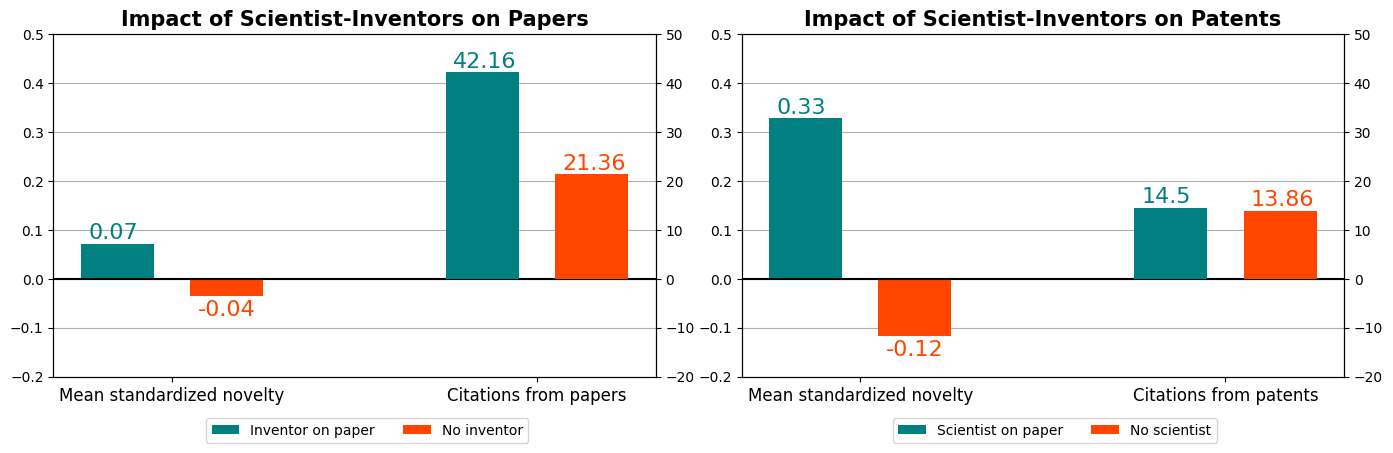

In [44]:
## plot the mean

import numpy as np 
import matplotlib.pyplot as plt 
import mpl_axes_aligner

fig,axes  = plt.subplots(1, 2, figsize=(14,5))

# set width of bar 
barWidth = 0.20

# Set position of bar on X axis 
br1 = np.arange(1) 
br2 = [x + 0.1 + barWidth for x in br1] 
br3 = np.arange(1,2) 
br4 = [x + 0.1 + barWidth for x in br3] 

ax1 = axes[0]
ax3 = axes[1]


# set height of bar 
patentsSIs = [mean_novelty_patents_SI,mean_cites_patents_SI] 
patentsNO_SIs = [ mean_novelty_patents_no_SI,mean_cites_patents_no_SI]

# set height of bar 
papersSIs = [mean_novelty_papers_SI,mean_cites_papers_SI] 
papersNO_SIs = [ mean_novelty_papers_no_SI,mean_cites_papers_no_SI] 




# Adding Xticks 
ax1.set_title('Impact of Scientist-Inventors on Papers', fontweight ='bold', fontsize = 15) 
ax1.set_xticks([r + ( barWidth + 0.1)/2  for r in range(2)], [ 'Mean standardized novelty','Citations from papers'], fontsize = 12)

ax1.set_axisbelow(True)
ax1.grid(axis='y')
ax1.legend( bbox_to_anchor=(0.85, -0.1), ncols = 2)

#ax1.set_ylabel('mean standardized novelty')
ax1.bar(br1, papersSIs[:1], color ='teal', width = barWidth, 
         label ='Inventor on paper') 
ax1.bar(br2, papersNO_SIs[:1], color ='orangered', width = barWidth, 
         label ='No inventor') 
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(br3, papersSIs[1:], color ='teal', width = barWidth, 
         label ='Inventor on paper') 
ax2.bar(br4, papersNO_SIs[1:], color ='orangered', width = barWidth, 
         label ='No inventor') 
ax1.axhline(0, color='k')


ax2.text(br3[0] - 0.08 , papersSIs[1] + 1 ,  round(papersSIs[1],2) , color = 'teal', fontsize = 16)
ax1.text(br1[0] - 0.08 , papersSIs[0] + 0.01  ,  round(papersSIs[0],2) , color = 'teal', fontsize = 16)
ax2.text(br4[0] - 0.08 , papersNO_SIs[1] + 1 ,  round(papersNO_SIs[1],2) , color = 'orangered', fontsize = 16)
ax1.text(br2[0] - 0.08, papersNO_SIs[0] - 0.04  ,  round(papersNO_SIs[0],2) , color = 'orangered', fontsize = 16)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


# Adding Xticks 
ax3.set_title('Impact of Scientist-Inventors on Patents', fontweight ='bold', fontsize = 15) 
ax3.set_xticks([r + ( barWidth + 0.1)/2  for r in range(2)], [ 'Mean standardized novelty','Citations from patents'], fontsize = 12)

ax3.set_axisbelow(True)
ax3.grid(axis='y')
ax3.legend( bbox_to_anchor=(0.85, -0.1), ncols = 2)

ax3.bar(br1, patentsSIs[:1], color ='teal', width = barWidth, 
         label ='Scientist on paper') 
ax3.bar(br2, patentsNO_SIs[:1], color ='orangered', width = barWidth, 
         label ='No scientist') 
ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax4.bar(br3, patentsSIs[1:], color ='teal', width = barWidth, 
         label ='Scientist on patent') 
ax4.bar(br4, patentsNO_SIs[1:], color ='orangered', width = barWidth, 
         label ='No scientist') 


ax4.text(br3[0] - 0.08 , patentsSIs[1] + 1 ,  round(patentsSIs[1],2) , color = 'teal', fontsize = 16)
ax3.text(br1[0] - 0.08 , patentsSIs[0] + 0.01  ,  round(patentsSIs[0],2) , color = 'teal', fontsize = 16)
ax4.text(br4[0] - 0.08 , patentsNO_SIs[1] + 1 ,  round(patentsNO_SIs[1],2) , color = 'orangered', fontsize = 16)
ax3.text(br2[0] - 0.08 , patentsNO_SIs[0] - 0.04  ,  round(patentsNO_SIs[0],2) , color = 'orangered', fontsize = 16)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax3.axhline(0, color='k')

ax3.legend( bbox_to_anchor=(0.8, -0.1), ncols = 2)
ax1.legend( bbox_to_anchor=(0.8, -0.1), ncols = 2)

ax1.set_yticks(np.linspace(-0.2,0.5,8))
ax2.set_yticks(np.linspace(-20,50,8))

ax3.set_yticks(np.linspace(-0.2,0.5,8))
ax4.set_yticks(np.linspace(-20,50,8))


plt.show() 



In [104]:
## calculate the mean of citations and novelty for SIs and NO SIs 

mean_cites_papers_a_SI = file_papers[(file_papers['number_active_gks'] > 0)]['cites'].mean()
mean_cites_papers_c_SI = file_papers[(file_papers['number_career_gks'] > 0)]['cites'].mean()
mean_cites_papers_no_SI = file_papers[(file_papers['number_active_gks'] == 0) & (file_papers['number_career_gks'] == 0)]['cites'].mean()

mean_novelty_papers_a_SI = file_papers[(file_papers['number_active_gks'] > 0)]['novelty_norm'].mean()
mean_novelty_papers_c_SI = file_papers[(file_papers['number_career_gks'] > 0)]['novelty_norm'].mean()
mean_novelty_papers_no_SI = file_papers[(file_papers['number_active_gks'] == 0) & (file_papers['number_career_gks'] == 0)]['novelty_norm'].mean()

mean_cites_patents_a_SI = file_patents[(file_patents['active_gk'] > 0)]['cites'].mean()
mean_cites_patents_c_SI = file_patents[(file_patents['career_gk'] > 0)]['cites'].mean()
mean_cites_patents_no_SI = file_patents[(file_patents['active_gk'] == 0) & (file_patents['career_gk'] == 0)]['cites'].mean()

mean_novelty_patents_a_SI = (file_patents[(file_patents['active_gk'] > 0)]['novelty_norm']).mean()
mean_novelty_patents_c_SI = (file_patents[(file_patents['career_gk'] > 0)]['novelty_norm']).mean()
mean_novelty_patents_no_SI = (file_patents[(file_patents['active_gk'] == 0) & (file_patents['career_gk'] == 0)]['novelty_norm']).mean()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


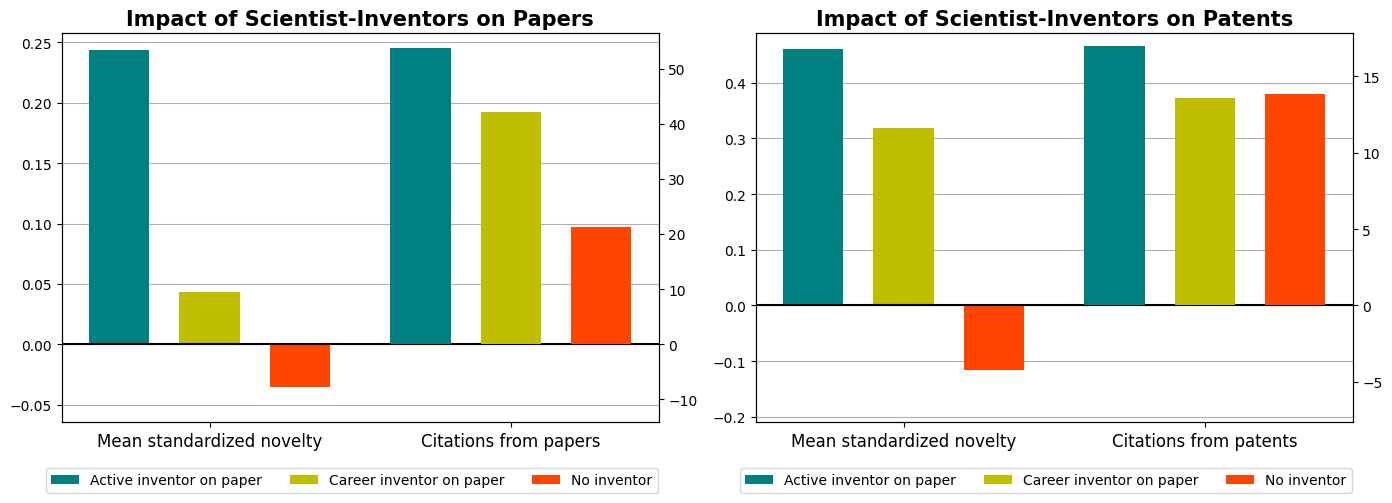

In [133]:
## plot the mean

import numpy as np 
import matplotlib.pyplot as plt 
import mpl_axes_aligner

fig,axes  = plt.subplots(1, 2, figsize=(14,5))

# set width of bar 
barWidth = 0.20

# Set position of bar on X axis 
br1 = np.arange(1) 
br2 = [x + 0.1 + barWidth for x in br1] 
br3 = [x + 0.1 + barWidth for x in br2] 
br4 = np.arange(1,2) 
br5 = [x + 0.1 + barWidth for x in br4] 
br6 = [x + 0.1 + barWidth for x in br5] 

ax1 = axes[0]
ax3 = axes[1]


# set height of bar 
patents_a_SIs = [mean_novelty_patents_a_SI,mean_cites_patents_a_SI,] 
patents_c_SIs = [mean_novelty_patents_c_SI,mean_cites_patents_c_SI] 
patentsNO_SIs = [ mean_novelty_patents_no_SI,mean_cites_patents_no_SI]

# set height of bar 
papers_a_SIs = [mean_novelty_papers_a_SI,mean_cites_papers_a_SI] 
papers_c_SIs = [mean_novelty_papers_c_SI,mean_cites_papers_c_SI] 
papersNO_SIs = [mean_novelty_papers_no_SI,mean_cites_papers_no_SI] 


# Adding Xticks 
ax1.set_title('Impact of Scientist-Inventors on Papers', fontweight ='bold', fontsize = 15) 
ax1.set_xticks([r + ( barWidth + 0.4)/2  for r in range(2)], [ 'Mean standardized novelty','Citations from papers'], fontsize = 12)

ax1.set_axisbelow(True)
ax1.grid(axis='y')
ax1.legend( bbox_to_anchor=(0.85, -0.1), ncols = 2)

#ax1.set_ylabel('mean standardized novelty')
ax1.bar(br1, papers_a_SIs[:1], color ='teal', width = barWidth, 
         label ='Active inventor on paper') 
ax1.bar(br2, papers_c_SIs[:1], color ='y', width = barWidth, 
         label ='Career inventor on paper') 
ax1.bar(br3, papersNO_SIs[:1], color ='orangered', width = barWidth, 
         label ='No inventor') 
ax1.tick_params(axis='y')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.set_ylabel('citations from papers')  # we already handled the x-label with ax1
ax2.bar(br4, papers_a_SIs[1:], color ='teal', width = barWidth, 
         label ='Active inventor on paper') 
ax2.bar(br5, papers_c_SIs[1:], color ='y', width = barWidth, 
         label ='Carrer inventor on paper') 
ax2.bar(br6, papersNO_SIs[1:], color ='orangered', width = barWidth, 
         label ='No inventor') 
ax2.tick_params(axis='y')
ax1.axhline(0, color='k')

mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped




# Adding Xticks 
ax3.set_title('Impact of Scientist-Inventors on Patents', fontweight ='bold', fontsize = 15) 
ax3.set_xticks([r + ( barWidth + 0.4)/2  for r in range(2)], [ 'Mean standardized novelty','Citations from patents'], fontsize = 12)

ax3.set_axisbelow(True)
ax3.grid(axis='y')

ax3.bar(br1, patents_a_SIs[:1], color ='teal', width = barWidth, 
         label ='Active inventor on paper') 
ax3.bar(br2, patents_c_SIs[:1], color ='y', width = barWidth, 
         label ='Career inventor on paper') 
ax3.bar(br3, patentsNO_SIs[:1], color ='orangered', width = barWidth, 
         label ='No inventor') 
ax3.tick_params(axis='y')
ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

ax4.bar(br4, patents_a_SIs[1:], color ='teal', width = barWidth, 
         label ='Active inventor on paper') 
ax4.bar(br5, patents_c_SIs[1:], color ='y', width = barWidth, 
         label ='Carrer inventor on paper') 
ax4.bar(br6, patentsNO_SIs[1:], color ='orangered', width = barWidth, 
         label ='No inventor') 
ax4.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped


ax3.axhline(0, color='k')
mpl_axes_aligner.align.yaxes(ax3, 0, ax4, 0, 0.3)

ax3.legend( bbox_to_anchor=(1.01, -0.1), ncols = 3)
ax1.legend( bbox_to_anchor=(1.01, -0.1), ncols = 3)

plt.show() 



In [2]:
## load files 

file_papers = pd.read_csv(main_path + "regressions/papers_citers_novelty_regression_magdates.tsv", delimiter = "\t", index_col=0)
file_patents = pd.read_stata(main_path + 'regressions/patents_cites_novelty_05.dta')

In [3]:
## calculate proportion of papers/patents and cites with and without SIs

prop_patents_SIs_papers = file_papers[ (file_papers['number_active_gks'] > 0) | (file_papers['number_career_gks'] > 0) ][['year','work_id']].groupby('year').count() / file_papers[['year','work_id']].groupby('year').count()
prop_cites_SIs_papers = file_papers[ (file_papers['number_active_gks'] > 0) | (file_papers['number_career_gks'] > 0) ][['year','cites']].groupby('year').sum() / file_papers[['year','cites']].groupby('year').sum()

prop_patents_SI_patents = file_patents[ (file_patents['active_gk'] > 0) | (file_patents['career_gk'] > 0)][['year','patent_id']].groupby('year').count() / file_patents[['year','patent_id']].groupby('year').count()
prop_cites_SI_patents = file_patents[ (file_patents['active_gk'] > 0)  | (file_patents['career_gk'] > 0)][['year','cites']].groupby('year').sum() / file_patents[['year','cites']].groupby('year').sum()


In [101]:
## print the proportion 

print("Proportion of papers by SIs: " , 100*prop_patents_SIs_papers[prop_patents_SIs_papers.index.isin([ year for year in range(1980,2023)])].mean().to_list()[0])
print("Proportion of papers cites by SIs: " , 100*prop_cites_SIs_papers[prop_cites_SIs_papers.index.isin([ year for year in range(1980,2023)])].mean().to_list()[0])
print("Proportion of patents by SIs: " , 100*prop_patents_SI_patents[prop_patents_SI_patents.index.isin([ year for year in range(1980,2023)])].mean().to_list()[0])
print("Proportion of patents cites by SIs: " , 100*prop_cites_SI_patents[prop_cites_SI_patents.index.isin([ year for year in range(1980,2023)])].mean().to_list()[0])


Proportion of papers by SIs:  31.11728631395017
Proportion of papers cites by SIs:  43.91524552949229
Proportion of patents by SIs:  21.4587779805115
Proportion of patents cites by SIs:  22.905398796826184


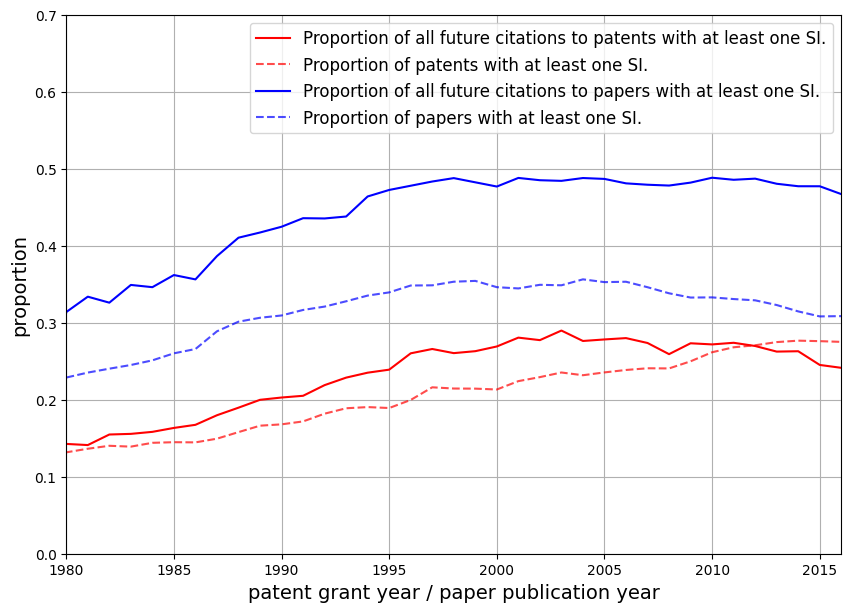

In [6]:
## plot the proportion over time 

plt.figure(figsize=(10,7))

plt.plot(prop_cites_SI_patents.index, prop_cites_SI_patents['cites'], label='Proportion of all future citations to patents with at least one SI.', color = 'red')
plt.plot(prop_patents_SI_patents, color = 'red', label= 'Proportion of patents with at least one SI.', linestyle='--', alpha = 0.7)


plt.plot(prop_cites_SIs_papers.index, prop_cites_SIs_papers['cites'], label='Proportion of all future citations to papers with at least one SI.', color = 'blue')
plt.plot(prop_patents_SIs_papers, color = 'blue', label= 'Proportion of papers with at least one SI.', linestyle = '--', alpha = 0.7)
plt.ylim([0,0.7])
plt.xlim([1980,2016])
plt.xlabel('patent grant year / paper publication year', fontsize=14)
plt.ylabel('proportion',fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

### Outliers 

In [24]:
file_papers.sort_values('number_only_authors', ascending = False)[:20]

,work_id,number_only_authors,number_active_gks,number_career_gks,pubyear,cites,backward_cites,Computer_science,Medicine,Biology,...,Chemistry,Materials_science,novelty,PPP,institution_int,concept1_int,top_5_percent,check_5percent,magid,year
index,,,,,,,,,,,,,,,,,,,,,
10505399,W2107578651,3136,8,60,2010,146,25,0,0,0,...,0,0,-0.003664,0,43467,-1,1,0,2.107579e+09,2010.0
11966277,W2143478461,3046,10,51,2012,35,36,0,0,0,...,0,0,-0.004707,0,3442,-1,0,0,2.143478e+09,2012.0
9277361,W2151512268,3006,7,63,2008,2393,141,0,0,0,...,0,0,0.015360,0,37,-1,1,0,2.151512e+09,2008.0
10980491,W2012695829,2991,7,51,2011,24,26,0,0,0,...,0,0,-0.014040,0,414,-1,0,0,2.012696e+09,2011.0
11174656,W2102430552,2974,6,50,2011,41,29,0,0,0,...,0,0,-0.006750,0,414,-1,0,0,2.102431e+09,2011.0
10852466,W1747920898,2969,8,53,2011,14,32,0,0,0,...,0,0,0.001445,0,3336,-1,0,0,1.747921e+09,2011.0
11895727,W2101748852,2964,10,47,2012,49,54,0,0,0,...,0,0,-0.017880,0,1652,-1,0,0,2.101749e+09,2012.0
11855521,W2082925097,2961,11,52,2012,11,15,1,0,1,...,0,1,-0.004353,0,19055,29,0,0,2.082925e+09,2012.0
12010264,W2169707159,2955,11,50,2012,251,7,0,0,1,...,0,0,-0.012184,0,1681,6,1,0,2.169707e+09,2012.0


In [26]:
file_patents['inventors'] = file_patents['only_inventors'] + file_patents['active_gk'] + file_patents['career_gk']
file_patents.sort_values('inventors', ascending = False)[:20]

,index,patent_id,cites,patent_date,has_assignee,PPP,year,science_citations,only_inventors,active_gk,...,C,D,E,F,G,H,Y,top_5_percent,assignee_type,inventors
364988,364988,10367677,51.0,2019-07-30,1.0,0,2019,57.0,52.0,49.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,COMPANY,133.0
1370308,1370308,11381445,0.0,2022-07-05,1.0,0,2022,65.0,52.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,,133.0
633352,633352,10638253,6.0,2020-04-28,1.0,0,2020,30.0,50.0,21.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,COMPANY,130.0
931144,931144,10938497,3.0,2021-03-02,1.0,0,2021,61.0,50.0,16.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,COMPANY,130.0
1639123,1639123,11652562,0.0,2023-05-16,1.0,0,2023,0.0,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,,130.0
625575,625575,10630410,29.0,2020-04-21,1.0,0,2020,61.0,50.0,21.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,COMPANY,130.0
5310012,5310012,7581231,13.0,2009-08-25,1.0,0,2009,21.0,71.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,COMPANY,76.0
1413007,1413007,11424539,2.0,2022-08-23,1.0,0,2022,46.0,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,,68.0
6331197,6331197,8606723,22.0,2013-12-10,1.0,0,2013,52.0,62.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,COMPANY,65.0
6418296,6418296,8694397,18.0,2014-04-08,1.0,0,2014,55.0,60.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,COMPANY,63.0


### Other plots 

In [ ]:
file = pd.read_csv(main_path + "regressions/papers_citers_novelty_regression_magdates.tsv", delimiter = "\t", index_col=0)

In [ ]:
prop_patents_active = file[ (file['number_active_gks'] > 0) ][['pubyear','work_id']].groupby('pubyear').count() / file[['pubyear','work_id']].groupby('pubyear').count()
prop_cites_active = file[ (file['number_active_gks'] > 0) ][['pubyear','cites']].groupby('pubyear').sum() / file[['pubyear','cites']].groupby('pubyear').sum()

prop_patents_SIs = file[ (file['number_active_gks'] > 0) | (file['number_career_gks'] > 0) ][['pubyear','work_id']].groupby('pubyear').count() / file[['pubyear','work_id']].groupby('pubyear').count()
prop_cites_SIs = file[ (file['number_active_gks'] > 0) | (file['number_career_gks'] > 0) ][['pubyear','cites']].groupby('pubyear').sum() / file[['pubyear','cites']].groupby('pubyear').sum()


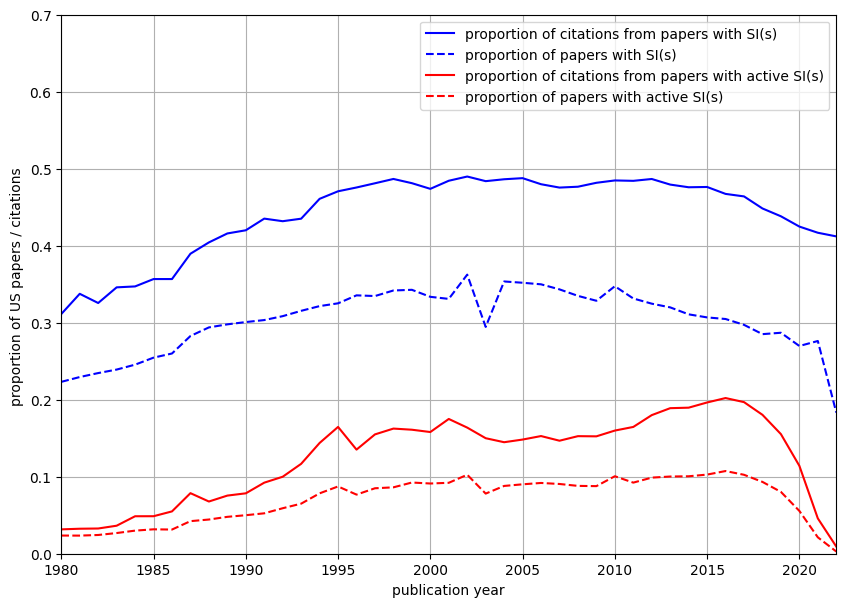

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.plot(prop_cites_SIs.index, prop_cites_SIs['cites'] , label = 'proportion of citations from papers with SI(s)', color = 'blue')
plt.plot(prop_patents_SIs,  label = 'proportion of papers with SI(s)', linestyle='--', color='blue')
plt.plot(prop_cites_active.index, prop_cites_active['cites'], label = 'proportion of citations from papers with active SI(s)', color = 'red')
plt.plot(prop_patents_active, label = 'proportion of papers with active SI(s)', linestyle='--', color='red')


plt.ylim([0,0.70])
plt.xlim([1980,2022])
plt.xlabel('publication year')
plt.ylabel('proportion of US papers / citations ')
plt.legend()
plt.grid()
plt.show()

In [12]:
prop_patents_active = file[ (file['number_active_gks'] > 0) ][['year','work_id']].groupby('year').count() / file[['year','work_id']].groupby('year').count()
prop_cites_active = file[ (file['number_active_gks'] > 0) ][['year','cites']].groupby('year').sum() / file[['year','cites']].groupby('year').sum()

prop_patents_SIs = file[ (file['number_active_gks'] > 0) | (file['number_career_gks'] > 0) ][['year','work_id']].groupby('year').count() / file[['year','work_id']].groupby('year').count()
prop_cites_SIs = file[ (file['number_active_gks'] > 0) | (file['number_career_gks'] > 0) ][['year','cites']].groupby('year').sum() / file[['year','cites']].groupby('year').sum()


In [14]:
prop_patents_active = prop_patents_active[prop_patents_active.index.isin([ year for year in range(1980,2022)])]
prop_cites_active = prop_cites_active[prop_cites_active.index.isin([ year for year in range(1980,2022)])]
prop_patents_SIs = prop_patents_SIs[prop_patents_SIs.index.isin([ year for year in range(1980,2022)])]
prop_cites_SIs = prop_cites_SIs[prop_cites_SIs.index.isin([ year for year in range(1980,2022)])]

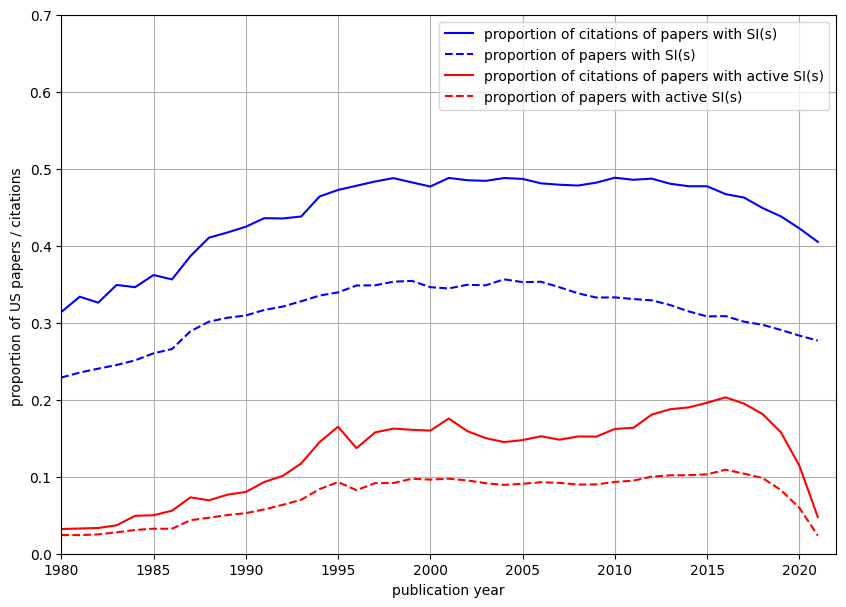

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.plot(prop_cites_SIs.index, prop_cites_SIs['cites'] , label = 'proportion of citations of papers with SI(s)', color = 'blue')
plt.plot(prop_patents_SIs,  label = 'proportion of papers with SI(s)', linestyle='--', color='blue')
plt.plot(prop_cites_active.index, prop_cites_active['cites'], label = 'proportion of citations of papers with active SI(s)', color = 'red')
plt.plot(prop_patents_active, label = 'proportion of papers with active SI(s)', linestyle='--', color='red')


plt.ylim([0,0.70])
plt.xlim([1980,2022])
plt.xlabel('publication year')
plt.ylabel('proportion of US papers / citations ')
plt.legend()
plt.grid()
plt.show()

In [21]:
file['pubyear'] = file['pubyear'].astype(int)
prop_cites_with_active_SI = file[ (file['number_active_gks'] > 0) ][['pubyear','cites']].groupby('pubyear').mean() 
prop_cites_with_career_SI = file[ (file['number_career_gks'] > 0) ][['pubyear','cites']].groupby('pubyear').mean() 
prop_cites_without_SI = file[ (file['number_active_gks']  == 0 ) &  (file['number_career_gks'] == 0 ) ][['pubyear','cites']].groupby('pubyear').mean() 
prop_cites = file[['pubyear','cites']].groupby('pubyear').mean() 

prop_cites_with_active_SI_sem = file[ (file['number_active_gks'] > 0) ][['pubyear','cites']].groupby('pubyear').sem() 
prop_cites_with_career_SI_sem = file[ (file['number_career_gks'] > 0) ][['pubyear','cites']].groupby('pubyear').sem() 
prop_cites_without_SI_sem = file[ (file['number_active_gks']  == 0 ) &  (file['number_career_gks'] == 0 ) ][['pubyear','cites']].groupby('pubyear').sem() 


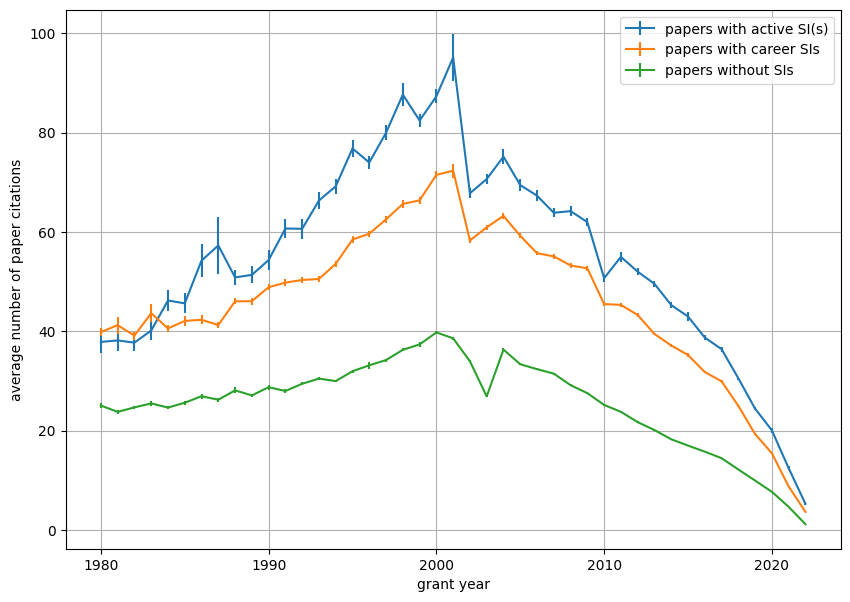

In [26]:
plt.figure(figsize=(10,7))

plt.errorbar(prop_cites_with_active_SI.index , prop_cites_with_active_SI['cites'], prop_cites_with_active_SI_sem['cites'])
plt.errorbar(prop_cites_with_career_SI.index ,prop_cites_with_career_SI['cites'], prop_cites_with_career_SI_sem['cites'] )
plt.errorbar(prop_cites_without_SI.index ,prop_cites_without_SI['cites'], prop_cites_without_SI_sem['cites'] )

plt.grid()
plt.xlabel('grant year')
plt.ylabel('average number of paper citations')
plt.legend(['papers with active SI(s)', 'papers with career SIs', 'papers without SIs'])
plt.show()

In [92]:
file_1author = file[file['Computer_science'] == 1]

no_si_cites = file_1author[( file_1author['number_active_gks'] == 0 ) & ( file_1author['number_career_gks'] == 0 )][['pubyear' ,'cites','concept1_int']].groupby(['pubyear','concept1_int']).mean().reset_index()[['pubyear','cites']].groupby('pubyear').mean()
active_cites =  file_1author[( file_1author['number_active_gks'] > 0 ) ][['pubyear' ,'cites','concept1_int']].groupby(['pubyear','concept1_int']).mean().reset_index()[['pubyear','cites']].groupby('pubyear').mean()
career_cites =  file_1author[( file_1author['number_career_gks'] > 0 ) ][['pubyear' ,'cites','concept1_int']].groupby(['pubyear','concept1_int']).mean().reset_index()[['pubyear','cites']].groupby('pubyear').mean()

no_si_cites_sem =  file_1author[( file_1author['number_active_gks'] == 0 ) & ( file_1author['number_career_gks'] == 0 )][['pubyear' ,'cites','concept1_int']].groupby(['pubyear','concept1_int']).mean().reset_index()[['pubyear','cites']].groupby('pubyear').sem()
active_cites_sem =  file_1author[( file_1author['number_active_gks'] > 0 ) ][['pubyear' ,'cites','concept1_int']].groupby(['pubyear','concept1_int']).mean().reset_index()[['pubyear','cites']].groupby('pubyear').sem()
career_cites_sem =  file_1author[( file_1author['number_career_gks'] > 0 ) ][['pubyear' ,'cites','concept1_int']].groupby(['pubyear','concept1_int']).mean().reset_index()[['pubyear','cites']].groupby('pubyear').sem()


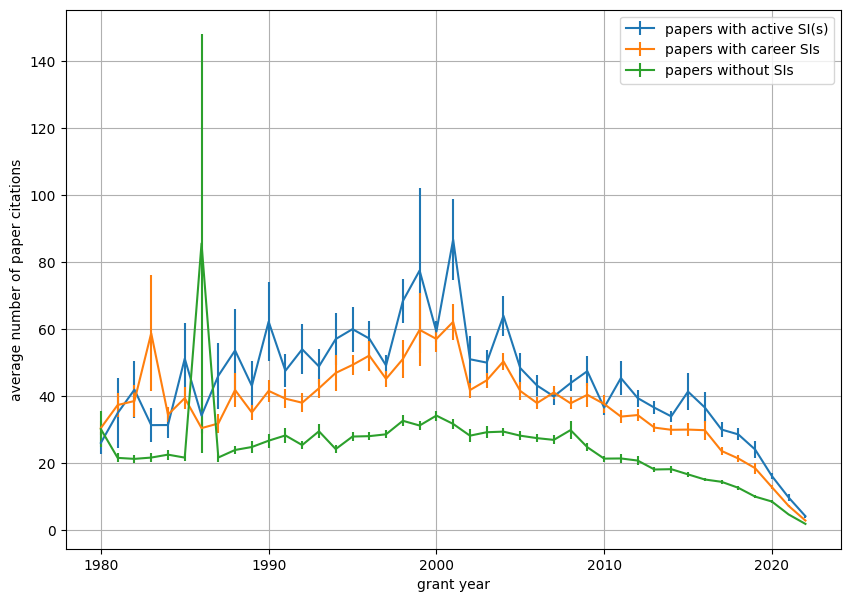

In [93]:
plt.figure(figsize=(10,7))

plt.errorbar(active_cites.index , active_cites['cites'], active_cites_sem['cites'])
plt.errorbar(career_cites.index , career_cites['cites'], career_cites_sem['cites'] )
plt.errorbar(no_si_cites.index ,no_si_cites['cites'], no_si_cites_sem['cites'] )

plt.grid()
plt.xlabel('grant year')
plt.ylabel('average number of paper citations')
plt.legend(['papers with active SI(s)', 'papers with career SIs', 'papers without SIs'])
plt.show()

In [54]:
file['total_authors'] = file['number_only_authors'] + file['number_active_gks'] + file['number_career_gks'] 

In [6]:
file_1author = file[file['Computer_science'] == 1]

no_si_novelty = - file_1author[( file_1author['number_active_gks'] == 0 ) & ( file_1author['number_career_gks'] == 0 )][['pubyear' ,'novelty','concept1_int']].groupby(['pubyear','concept1_int']).mean().reset_index()[['pubyear','novelty']].groupby('pubyear').mean()
active_novelty = - file_1author[( file_1author['number_active_gks'] > 0 ) ][['pubyear' ,'novelty','concept1_int']].groupby(['pubyear','concept1_int']).mean().reset_index()[['pubyear','novelty']].groupby('pubyear').mean()
career_novelty = - file_1author[( file_1author['number_career_gks'] > 0 ) ][['pubyear' ,'novelty','concept1_int']].groupby(['pubyear','concept1_int']).mean().reset_index()[['pubyear','novelty']].groupby('pubyear').mean()

no_si_novelty_sem =  file_1author[( file_1author['number_active_gks'] == 0 ) & ( file_1author['number_career_gks'] == 0 )][['pubyear' ,'novelty','concept1_int']].groupby(['pubyear','concept1_int']).sem().reset_index()[['pubyear','novelty']].groupby('pubyear').sem()
active_novelty_sem =  file_1author[( file_1author['number_active_gks'] > 0 ) ][['pubyear' ,'novelty','concept1_int']].groupby(['pubyear','concept1_int']).sem().reset_index()[['pubyear','novelty']].groupby('pubyear').sem()
career_novelty_sem =  file_1author[( file_1author['number_career_gks'] > 0 ) ][['pubyear' ,'novelty','concept1_int']].groupby(['pubyear','concept1_int']).sem().reset_index()[['pubyear','novelty']].groupby('pubyear').sem()


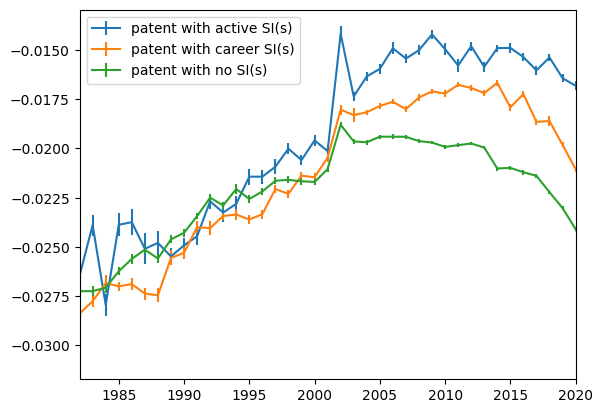

In [7]:
import matplotlib.pyplot as plt

plt.errorbar(active_novelty.index , active_novelty['novelty'] , active_novelty_sem['novelty'], label='patent with active SI(s)' ) 
plt.errorbar(career_novelty.index , career_novelty['novelty'] , career_novelty_sem['novelty'], label='patent with career SI(s)' ) 
plt.errorbar(no_si_novelty.index , no_si_novelty['novelty'] , no_si_novelty_sem['novelty'], label='patent with no SI(s)' ) 
plt.xlim([1982,2020])
plt.legend()
plt.show()